In [33]:
# Import Libraries
from scipy import stats
from numpy.random.mtrand import exponential
from numpy.random import normal
from statistics import mean
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Global Variabels
start_time = datetime.now()
# Anzahl Durchgänge in der Monte Carlo Simulation
sizeMonteCarloSim = 10000


listfeatures_samples = pd.DataFrame()

#Function for fitting a distribution on values of a column
def FindmostfittingDistribution(MatrixColumn):

    # List of available Distributions for fitting in scipy
    list_of_dists = ['beta', 'cauchy', 'chi', 'chi2',
                     'expon', 'logistic', 'norm', 'pareto', 't', 'uniform','gamma']

    results = []
    for i in list_of_dists:
        dist = getattr(stats, i)
        param = dist.fit(MatrixColumn)
        a = stats.kstest(MatrixColumn, i, args=param)
        results.append((i, a[0], a[1]))

    results.sort(key=lambda x: float(x[2]), reverse=True)
    for j in results:
        print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))
        
        

#Function for Reading CSV File to Dataframe
def ReadDataframe():
    ##Read first CSV File
    dataFile1 = pd.read_csv("out_1.csv")
    ##Read second CSV File
    dataFile2 = pd.read_csv("out_2.csv")

    #Add Zone columns
    dataFile1['zone']='1'
    dataFile2['zone']='2'

    #Append File 2 to File 1
    mergedDataFile = dataFile1.append(dataFile2)
    return mergedDataFile


# Calculate and Update Columns
def CalculateandUpdateColumns(mergedDataFile):
    
    #Add Energy in KJ column formula(KE=1/2mv^2)/1000 in m = kg and v = m/s
    mergedDataFile['energy']=((mergedDataFile['mass']/2)*(mergedDataFile['velocity']**2) / 1000)

    # Add Trigger if stone has fallen
    mergedDataFile["Trigger"] = np.where(mergedDataFile["zone"] == 0, 0, 1) 

    # Create Datetime Column
    mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])

    # Change Hour if two stones at same time
    mergedDataFile = mergedDataFile.sort_values(by=['DateTime'])
    mergedDataFile = mergedDataFile.reset_index(drop=True)
    mergedDataFile.loc[1, 'timestamp'] = "10:00"
    mergedDataFile.loc[44, 'timestamp'] = "13:00"
    mergedDataFile.loc[89, 'timestamp'] = "13:00"

    # Update Datetime Column
    mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])


    # Fill missing hours
    dfTimeSerie = mergedDataFile
    dfTimeSerie = dfTimeSerie.set_index(mergedDataFile["DateTime"])

    dfTimeSerie = dfTimeSerie.resample('H').first().fillna(0)
    dfTimeSerie['DateTime'] = dfTimeSerie.index

    # Fill new missing days and hours in date and timestamp
    dfTimeSerie["date"] = dfTimeSerie["DateTime"].dt.date
    dfTimeSerie["timestamp"] = dfTimeSerie["DateTime"].dt.time

    # Calculate Time before next Stone
    mergedDataFileZone1 = mergedDataFile.loc[mergedDataFile['zone'] == "1"]
    TimebeforeStone1 =mergedDataFileZone1["DateTime"].diff()
    mergedDataFileZone1["TimebeforeStone"] = TimebeforeStone1.astype('timedelta64[h]').fillna(0)


    mergedDataFileZone2 = mergedDataFile.loc[mergedDataFile['zone'] == "2"]
    TimebeforeStone2 =mergedDataFileZone2["DateTime"].diff()
    mergedDataFileZone2["TimebeforeStone"] = TimebeforeStone2.astype('timedelta64[h]').fillna(0)


    mergedDataFile = mergedDataFileZone1.append(mergedDataFileZone2)

    # Rolling 24h
    dfTimeSerie["rollingEnergy24h"] = dfTimeSerie["energy"].rolling(24, min_periods=1).sum()
    dfTimeSerie["rollingmass24h"] = dfTimeSerie["mass"].rolling(24, min_periods=1).sum()


    # Calculate Breach
    dfTimeSerie["BreachEnergy"] = np.where(dfTimeSerie["energy"] >= 1000, 1, 0)
    dfTimeSerie["BreachFullNet"] = np.where((dfTimeSerie["energy"] >= 500) & (dfTimeSerie["rollingmass24h"] >= 2000), 1, 0)
    # Theoretisch müsste man dfTimeSerie["rollingmass24h"] von der Reihe darüber nehmen, nun wird auch der neue Stein dazugezählt.
    return mergedDataFile

In [34]:
mergedDataFile = ReadDataframe()
mergedDataFile = CalculateandUpdateColumns(mergedDataFile)
dataFile1 = mergedDataFile.loc[mergedDataFile['zone'] == "1"]
dataFile2 = mergedDataFile.loc[mergedDataFile['zone'] == "2"]

Time_Import = datetime.now()


<ipython-input-33-24e3efbb713b>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergedDataFileZone1["TimebeforeStone"] = TimebeforeStone1.astype('timedelta64[h]').fillna(0)
<ipython-input-33-24e3efbb713b>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergedDataFileZone2["TimebeforeStone"] = TimebeforeStone2.astype('timedelta64[h]').fillna(0)


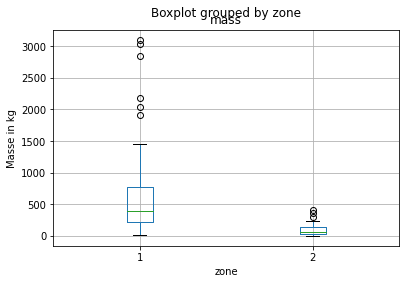

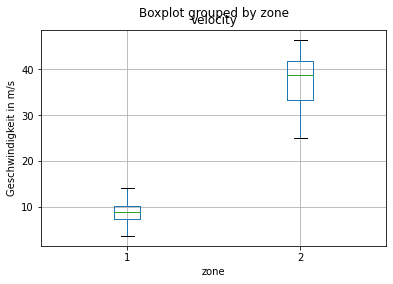

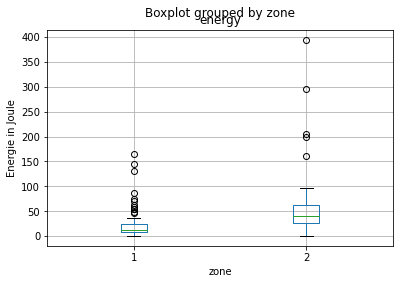

In [31]:
mergedDataFile.boxplot(column = "mass", by = "zone")
plt.ylabel("Masse in kg")
plt.show()

mergedDataFile.boxplot(column = "velocity", by = "zone")
plt.ylabel("Geschwindigkeit in m/s")
plt.show()

mergedDataFile.boxplot(column = "energy", by = "zone")
plt.ylabel("Energie in Joule")
plt.show()

In [42]:
#Definition der Verteilungsinformationen für die Zonen
listfeatures_distributions_zone1 = [["mass", "exponential"], [
    "velocity", "normal"], ["TimebeforeStone", "exponential"]]
listfeatures_distributions_zone2 = [["mass", "exponential"], [
    "velocity", "normal"], ["TimebeforeStone", "exponential"]]

# Second Mainloop for zone calculations
# Zone 1
listfeatures_samples_zone_1 = pd.DataFrame()
zoneindex = 0

for featureDistribution in listfeatures_distributions_zone1:
    zoneindex = 1
    # calc fit dist features case when dist predefined
    if (featureDistribution[1] == "exponential"):
        explambda = mean(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.exponential(explambda,sizeMonteCarloSim)
        
        listfeatures_samples_zone_1[featureDistribution[0]] = sample
        featureDistribution_zone1 = np.append(featureDistribution, sample)

    elif(featureDistribution[1] == "normal"):
        meanTruncated = mean(dataFile1[featureDistribution[0]])
        stdTruncated = np.std(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.normal(meanTruncated, stdTruncated,
                        size=sizeMonteCarloSim)
        listfeatures_samples_zone_1[featureDistribution[0]] = sample
    elif(featureDistribution[1] == "gamma"):
        meanTruncated = mean(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.gamma(meanTruncated,
                        size=sizeMonteCarloSim)
        listfeatures_samples_zone_1[featureDistribution[0]] = sample

# Zone 2
listfeatures_samples_zone_2 = pd.DataFrame()
zoneindex = 0

for featureDistribution in listfeatures_distributions_zone2:
    zoneindex = 2
    # calc fit dist features case when dist predefined
    if (featureDistribution[1] == "exponential"):
        explambda = mean(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.exponential(explambda, size=sizeMonteCarloSim)
        listfeatures_samples_zone_2[featureDistribution[0]] = sample
        listfeatures_distributions_zone2 = np.append(
            featureDistribution, sample)
    elif(featureDistribution[1] == "normal"):
        meanTruncated = mean(dataFile1[featureDistribution[0]])
        stdTruncated = np.std(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.normal(meanTruncated, stdTruncated,
                        size=sizeMonteCarloSim)
        listfeatures_samples_zone_2[featureDistribution[0]] = sample
    elif(featureDistribution[1] == "gamma"):
        meanTruncated = mean(dataFile2[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.gamma(meanTruncated,
                        size=sizeMonteCarloSim)
        listfeatures_samples_zone_2[featureDistribution[0]] = sample

Timer_after_MonteCarlo = datetime.now()

In [43]:
# Berechnung der Energie der simulierten Steinschläge pro Zone
listfeatures_samples_zone_1['energy'] = (
    (listfeatures_samples_zone_1['mass']/2)*(listfeatures_samples_zone_1['velocity']**2) / 1000)
listfeatures_samples_zone_2['energy'] = (
    (listfeatures_samples_zone_2['mass']/2)*(listfeatures_samples_zone_2['velocity']**2) / 1000)
# # Markierung der Steine, die mit der Energie das Netz durchschlagen haben
listfeatures_samples_zone_1['direct_breakthrough'] = np.where(
    (listfeatures_samples_zone_1["energy"] >= 1000), 1, 0)
listfeatures_samples_zone_2['direct_breakthrough'] = np.where(
    (listfeatures_samples_zone_2["energy"] >= 1000), 1, 0)

listfeatures_samples_zone_1['Zone'] = 1
listfeatures_samples_zone_2['Zone'] = 2

Timer_after_Calc_Energy_directbreakthrough = datetime.now()

# Berechnung Masse im Netz

listfeatures_samples_zone_1["CumsumHoursbeforeStone"] = listfeatures_samples_zone_1["TimebeforeStone"].cumsum()
Timer_after_Cumsum1 = datetime.now()
listfeatures_samples_zone_2["CumsumHoursbeforeStone"] = listfeatures_samples_zone_2["TimebeforeStone"].cumsum()
Timer_after_Cumsum2 = datetime.now()


listfeatures_samples = listfeatures_samples_zone_1.append(listfeatures_samples_zone_2, ignore_index=True)
Timer_after_Merge = datetime.now()


listfeatures_samples = listfeatures_samples.sort_values(by='CumsumHoursbeforeStone')
listfeatures_samples = listfeatures_samples.reset_index(drop=True)
Timer_after_Merge_clean = datetime.now()


listfeatures_samples["Year"] = listfeatures_samples['CumsumHoursbeforeStone'].floordiv(8760)
Timer_after_Calc_Year = datetime.now()


# Berechnet, wieviel Masse pro Tag im Netz ist, aber nicht, ob es wegen dem letzten gerissen ist...
listfeatures_samples["Tag"] = listfeatures_samples['CumsumHoursbeforeStone'] // 24
Netzvoll = listfeatures_samples.groupby("Tag")["mass"].agg("sum")
Netzvoll = pd.DataFrame({'Tag': Netzvoll.index, 'Tagesmasse': Netzvoll.values})
listfeatures_samples = listfeatures_samples.merge(
    Netzvoll, how="left", on="Tag")
listfeatures_samples["PossibleBreachFullNet"] = np.where(
    (listfeatures_samples["energy"] >= 500) & (listfeatures_samples["Tagesmasse"] >= 2000), 1, 0)


CountBreachFullNet = 0
ListPossibleBrechFullNet = listfeatures_samples[listfeatures_samples["PossibleBreachFullNet"] == 1]
ListPossibleBrechFullNet = ListPossibleBrechFullNet.reset_index()
for i in range(len(ListPossibleBrechFullNet)):
    Day = ListPossibleBrechFullNet.loc[i, "Tag"]
    ToCheck = listfeatures_samples[listfeatures_samples["Tag"] == Day]
    ToCheck = ToCheck.reset_index()
    ToCheck["CumsumMass"] = ToCheck["mass"].shift().cumsum()
    for i in range(len(ToCheck)):
        if ToCheck.loc[i, "direct_breakthrough"] == 1:
            break  # break weil wenn das Netz durchbrochen ist, die Strasse gesperrt wird
        else:
            if (ToCheck.loc[i, "energy"] >= 500) & (ToCheck.loc[i, "CumsumMass"] >= 2000):
                CountBreachFullNet += 1
                break
    


print("Number of years:", listfeatures_samples["Year"].max())
print("Number of BreachFullNet:", CountBreachFullNet)
print("Number of direct breakthrough:",
      listfeatures_samples["direct_breakthrough"].sum())


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
print("Time Import", Time_Import - start_time)
print("Time Monte Carlo", Timer_after_MonteCarlo - Time_Import)
print("Time Calc Energy direct break",
      Timer_after_Calc_Energy_directbreakthrough - Timer_after_MonteCarlo)
print("Time Cumsum1", Timer_after_Cumsum1 -
      Timer_after_Calc_Energy_directbreakthrough)
print("Time Cumsum2", Timer_after_Cumsum2 - Timer_after_Cumsum1)
print("Time Merge", Timer_after_Merge - Timer_after_Cumsum2)
print("Time Merge cleaned", Timer_after_Merge_clean - Timer_after_Merge)
print("Time Calc Year", Timer_after_Calc_Year - Timer_after_Merge_clean)
print("Time Calc Poss full Net", end_time - Timer_after_Calc_Year)


Number of years: 35.0
Number of BreachFullNet: 0
Number of direct breakthrough: 0
Duration: 0:07:57.942609
Time Import 0:00:03.686940
Time Monte Carlo 0:07:47.051245
Time Calc Energy direct break 0:00:07.170422
Time Cumsum1 0:00:00.002062
Time Cumsum2 0:00:00.000979
Time Merge 0:00:00.000992
Time Merge cleaned 0:00:00.004974
Time Calc Year 0:00:00.001995
Time Calc Poss full Net 0:00:00.023000
